# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [ ]:
import heapq
def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn

class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)

In [ ]:
#from search import *
#from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Best First Search
* Uniform Cost Search
* Greedy Best First Search
* A\* Search

## OVERVIEW

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
    * Examples:
        1. Best First Search
        2. Uniform Cost Search
        3. A\* Search
        
*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in `notebook.py`.

In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [ ]:
class Problem(object):

    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [ ]:
class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node.

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node.

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [ ]:
class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = infinity
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return infinity

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [ ]:
class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict=graph_dict, directed=False)


def RandomGraph(nodes=list(range(10)), min_links=2, width=400, height=300,
                curvature=lambda: random.uniform(1.1, 1.5)):
    """Construct a random graph, with the specified nodes, and random links.
    The nodes are laid out randomly on a (width x height) rectangle.
    Then each node is connected to the min_links nearest neighbors.
    Because inverse links are added, some nodes will have more connections.
    The distance between nodes is the hypotenuse times curvature(),
    where curvature() defaults to a random number between 1.1 and 1.5."""
    g = UndirectedGraph()
    g.locations = {}
    # Build the cities
    for node in nodes:
        g.locations[node] = (random.randrange(width), random.randrange(height))
    # Build roads from each city to at least min_links nearest neighbors.
    for i in range(min_links):
        for node in nodes:
            if len(g.get(node)) < min_links:
                here = g.locations[node]

                def distance_to_node(n):
                    if n is node or g.get(node, n):
                        return np.inf
                    return distance(g.locations[n], here)

                neighbor = min(nodes, key=distance_to_node)
                d = distance(g.locations[neighbor], here) * curvature()
                g.connect(node, neighbor, int(d))
    return g

In [ ]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph.

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [ ]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [ ]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [ ]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

In [ ]:
def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(9, 7))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k',node_size= 100,)

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=9)

    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=9)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=11, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=11, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=11, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=11, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=11, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 11}, loc=(.8, .75))

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()


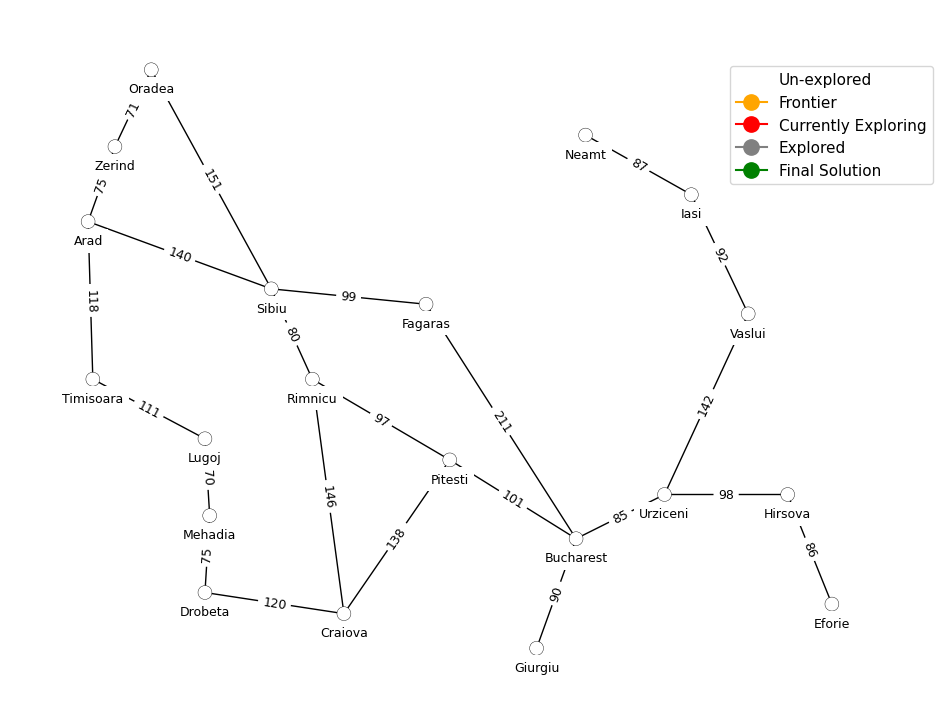

In [ ]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SIMPLE PROBLEM SOLVING AGENT PROGRAM

Let us now define a Simple Problem Solving Agent Program. Run the next cell to see how the abstract class `SimpleProblemSolvingAgentProgram` is defined in the search module.

In [ ]:
class SimpleProblemSolvingAgentProgram:

    """Abstract framework for a problem-solving agent. [Figure 3.1]"""

    def __init__(self, initial_state=None):
        """State is an abstract representation of the state
        of the world, and seq is the list of actions required
        to get to a particular state from the initial state(root)."""
        self.state = initial_state
        self.seq = []

    def __call__(self, percept):
        """[Figure 3.1] Formulate a goal and problem, then
        search for a sequence of actions to solve it."""
        self.state = self.update_state(self.state, percept)
        if not self.seq:
            goal = self.formulate_goal(self.state)
            problem = self.formulate_problem(self.state, goal)
            self.seq = self.search(problem)
            if not self.seq:
                return None
        return self.seq.pop(0)

    def update_state(self, state, percept):
        raise NotImplementedError

    def formulate_goal(self, state):
        raise NotImplementedError

    def formulate_problem(self, state, goal):
        raise NotImplementedError

    def search(self, problem):
        raise NotImplementedError

The SimpleProblemSolvingAgentProgram class has six methods:  

* `__init__(self, intial_state=None)`: This is the `contructor` of the class and is the first method to be called when the class is instantiated. It takes in a keyword argument, `initial_state` which is initially `None`. The argument `initial_state` represents the state from which the agent starts.

* `__call__(self, percept)`: This method updates the `state` of the agent based on its `percept` using the `update_state` method. It then formulates a `goal` with the help of `formulate_goal` method and a `problem` using the `formulate_problem` method and returns a sequence of actions to solve it (using the `search` method).

* `update_state(self, percept)`: This method updates the `state` of the agent based on its `percept`.

* `formulate_goal(self, state)`: Given a `state` of the agent, this method formulates the `goal` for it.

* `formulate_problem(self, state, goal)`: It is used in problem formulation given a `state` and a `goal` for the `agent`.

* `search(self, problem)`: This method is used to search a sequence of `actions` to solve a `problem`.

Let us now define a Simple Problem Solving Agent Program. We will create a simple `vacuumAgent` class which will inherit from the abstract class `SimpleProblemSolvingAgentProgram` and overrides its methods. We will create a simple intelligent vacuum agent which can be in any one of the following states. It will move to any other state depending upon the current state as shown in the picture by arrows:

![simple problem solving agent](images/simple_problem_solving_agent.jpg)

In [ ]:
class vacuumAgent(SimpleProblemSolvingAgentProgram):
        def update_state(self, state, percept):
            return percept

        def formulate_goal(self, state):
            goal = [state7, state8]
            return goal

        def formulate_problem(self, state, goal):
            problem = state
            return problem

        def search(self, problem):
            if problem == state1:
                seq = ["Suck", "Right", "Suck"]
            elif problem == state2:
                seq = ["Suck", "Left", "Suck"]
            elif problem == state3:
                seq = ["Right", "Suck"]
            elif problem == state4:
                seq = ["Suck"]
            elif problem == state5:
                seq = ["Suck"]
            elif problem == state6:
                seq = ["Left", "Suck"]
            return seq

Now, we will define all the 8 states and create an object of the above class. Then, we will pass it different states and check the output:

In [ ]:
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = vacuumAgent(state1)

print(a(state6))
print(a(state1))
print(a(state3))

Left
Suck
Right


## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:

1. Breadth First Tree Search
2. Depth First Tree Search
3. Breadth First Search
4. Depth First Graph Search
5. Best First Graph Search
6. Uniform Cost Search
7. Depth Limited Search
8. Iterative Deepening Search
9. Greedy Best First Search
9. A\*-Search
10. Recursive Best First Search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

## 1. BREADTH-FIRST TREE SEARCH

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.

In [ ]:
def tree_breadth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""

    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    #Adding first node to the queue
    frontier = deque([Node(problem.initial)])

    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    while frontier:
        #Popping first node of queue
        node = frontier.popleft()

        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        frontier.extend(node.expand(problem))

        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))

    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_breadth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

Now, we use `ipywidgets` to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.

In [ ]:
def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."

    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"
    return final_colors


def display_visual(graph_data, user_input, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors']
    if user_input is False:
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(graph_data, node_colors=all_node_colors[iteration])
            except:
                pass

        def visualize_callback(visualize):
            if visualize is True:
                button.value = False

                global all_node_colors

                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    # time.sleep(.5)

        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration=slider)
        display(slider_visual)

        button = widgets.ToggleButton(value=False)
        button_visual = widgets.interactive(visualize_callback, visualize=button)
        display(button_visual)

    if user_input is True:
        node_colors = dict(initial_node_colors)
        if isinstance(algorithm, dict):
            assert set(algorithm.keys()).issubset({"Breadth First Tree Search",
                                                   "Depth First Tree Search",
                                                   "Breadth First Search",
                                                   "Depth First Graph Search",
                                                   "Best First Graph Search",
                                                   "Uniform Cost Search",
                                                   "Depth Limited Search",
                                                   "Iterative Deepening Search",
                                                   "Greedy Best First Search",
                                                   "A-star Search",
                                                   "Recursive Best First Search"})

            algo_dropdown = widgets.Dropdown(description="Search algorithm: ",
                                             options=sorted(list(algorithm.keys())),
                                             value="Breadth First Tree Search")
            display(algo_dropdown)
        elif algorithm is None:
            print("No algorithm to run.")
            return 0

        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(graph_data, node_colors=all_node_colors[iteration])
            except:
                pass

        def visualize_callback(visualize):
            if visualize is True:
                button.value = False

                problem = GraphProblem(start_dropdown.value, end_dropdown.value, romania_map)
                global all_node_colors

                user_algorithm = algorithm[algo_dropdown.value]

                iterations, all_node_colors, node = user_algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    # time.sleep(.5)

        start_dropdown = widgets.Dropdown(description="Start city: ",
                                          options=sorted(list(node_colors.keys())), value="Arad")
        display(start_dropdown)

        end_dropdown = widgets.Dropdown(description="Goal city: ",
                                        options=sorted(list(node_colors.keys())), value="Fagaras")
        display(end_dropdown)

        button = widgets.ToggleButton(value=False)
        button_visual = widgets.interactive(visualize_callback, visualize=button)
        display(button_visual)

        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration=slider)
        display(slider_visual)



In [ ]:
from collections import deque


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
a, b, c = breadth_first_tree_search(romania_problem)
display_visual(romania_graph_data, user_input=False,
               algorithm=breadth_first_tree_search,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2. DEPTH-FIRST TREE SEARCH
Now let's discuss another searching algorithm, Depth-First Tree Search.

In [ ]:
def tree_depth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""

    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    #Adding first node to the stack
    frontier = [Node(problem.initial)]

    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    while frontier:
        #Popping first node of stack
        node = frontier.pop()

        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        frontier.extend(node.expand(problem))

        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))

    return None

def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = tree_depth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=depth_first_tree_search,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 3. BREADTH-FIRST GRAPH SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [ ]:
def breadth_first_search_graph(problem):
    "[Figure 3.11]"

    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    node = Node(problem.initial)

    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)

    frontier = deque([node])

    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    explored = set()
    while frontier:
        node = frontier.popleft()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        explored.add(node.state)

        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=breadth_first_search_graph,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 4. DEPTH-FIRST GRAPH SEARCH
Although we have a working implementation in search module, we have to make a few changes in the algorithm to make it suitable for visualization.

In [ ]:
def graph_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    frontier = [(Node(problem.initial))]
    explored = set()

    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    while frontier:
        # Popping first node of stack
        node = frontier.pop()

        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)

        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))

    return None


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=depth_first_graph_search,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 5. BEST FIRST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [ ]:
def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""

    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    f = memoize(f, 'f')
    node = Node(problem.initial)

    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)

    frontier = PriorityQueue('min', f)
    frontier.append(node)

    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    explored = set()
    while frontier:
        node = frontier.pop()

        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

## 6. UNIFORM COST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [ ]:
def uniform_cost_search_graph(problem):
    "[Figure 3.14]"
    #Uniform Cost Search uses Best First Search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=uniform_cost_search_graph,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 7. DEPTH LIMITED SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  
Although we have a working implementation, but we need to make changes.

In [ ]:
def depth_limited_search_graph(problem, limit = -1):
    '''
    Perform depth first search of graph g.
    if limit >= 0, that is the maximum depth of the search.
    '''
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    frontier = [Node(problem.initial)]
    explored = set()

    cutoff_occurred = False
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    while frontier:
        # Popping first node of queue
        node = frontier.pop()

        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        elif limit >= 0:
            cutoff_occurred = True
            limit += 1
            all_node_colors.pop()
            iterations -= 1
            node_colors[node.state] = "gray"


        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)

        for n in frontier:
            limit -= 1
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))

    return 'cutoff' if cutoff_occurred else None


def depth_limited_search_for_vis(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = depth_limited_search_graph(problem)
    return(iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=depth_limited_search_for_vis,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 8. ITERATIVE DEEPENING SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  

In [ ]:
def iterative_deepening_search_for_vis(problem):
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node=depth_limited_search_for_vis(problem)
        if iterations:
            return (iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=iterative_deepening_search_for_vis,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 9. GREEDY BEST FIRST SEARCH
Let's change all the node_colors to starting position and define a different problem statement.

In [ ]:
def greedy_best_first_search(problem, h=None):
    """Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
    You need to specify the h function when you call best_first_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)


In [ ]:
import numpy as np
def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=greedy_best_first_search,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 10. A\* SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [ ]:
def astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem,
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=astar_search_graph,
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…